# Generalized Correlation Matrix Clustering example

## Function to plot the correlation matrix of a dataframe.

In [1]:
def plot_corr(df,size=10):
    '''Plot a graphical correlation matrix for a dataframe.

    Input:
        df: pandas DataFrame
        size: vertical and horizontal size of the plot'''
    
    %matplotlib inline
    import matplotlib.pyplot as plt

    # Compute the correlation matrix for the received dataframe
    corr = df.corr()
    
    # Plot the correlation matrix
    fig, ax = plt.subplots(figsize=(size, size))
    cax = ax.matshow(corr, cmap='RdYlGn')
    plt.xticks(range(len(corr.columns)), corr.columns, rotation=90);
    plt.yticks(range(len(corr.columns)), corr.columns);
    
    # Add the colorbar legend
    cbar = fig.colorbar(cax, ticks=[-1, 0, 1], aspect=40, shrink=.8)

## Function that performs the hierarchical clustering
We use hierarchical clustering to determine which columns belongs to which cluster.  
While generalizing the correlation matrix clustering, we took the opportunuity to make it works either on the original data or on a correlation matrix of that data thus easily adapting to different needs.

In [2]:
import scipy
import scipy.cluster.hierarchy as sch

def _clustering_pass(sub, is_corr):
    df = sub.copy()
    
    if is_corr: 
        X = df.values
    else:
        X = df.corr().values
    d = sch.distance.pdist(X)
    L = sch.linkage(d, method='complete')
    ind = sch.fcluster(L, 0.5*d.max(), 'distance')

    columns = [df.columns.tolist()[i] for i in list(np.argsort(ind))]
    df = df.reindex(columns, axis='columns')
    if is_corr: df = df.reindex(columns, axis='index')
    
    unique, counts = np.unique(ind, return_counts=True)
    counts = dict(zip(unique, counts))

    return (ind, counts, df)

def cluster_layer(sub, cluster_th, max_level, is_corr=False, level=1):
    '''Perform Hierarchical clustering on either raw data or a correlation matrix.

    Input:
        sub: pandas DataFrame of the data or correlation matrix of the data
        cluster_th: threshold of the size of the minimum cluster to sub cluster.
        max_level: maximum number of recursion allowed i.e. maximum of time we will sub cluster bigger clusters
        is_corr: if a correlation matrix is used as input, set to True
    Output:
        df: pandas DataFrame for which the columns (and rows if the input is a correlation matrix) 
            have been ordered according to the hierarchical clustering'''
    df = sub.copy()
    ind, counts, df = _clustering_pass(df, is_corr)

    print('level: {} shape of the matrix clustered: {}'.format(level, df.shape))
    
    if level < max_level:
        i = 0
        j = 0
        columns = []
        for cluster_l1 in set(sorted(ind)):
            j += counts[cluster_l1]
            if is_corr:
                sub = df.iloc[i:j,i:j]
            else:
                sub = df[df.columns.values[i:j]]
            if counts[cluster_l1]>cluster_th:        
                sub = cluster_layer(sub, cluster_th, max_level, is_corr, level+1)

            cols = sub.columns.tolist()
            columns.extend(cols)
            i = j
        df = df.reindex(columns, axis='columns')
        if is_corr: df = df.reindex(columns, axis='index')
    
    return df

## Generate example data

In [3]:
import pandas as pd
import numpy as np

# Generate 50 variables with 1000 samples
n_variables = 50
n_samples = 1000

# Those variables will be spread over 3 clusters of variable sizes
cluster_size = [5,22,28]
n_clusters = len(cluster_size)

# Assign each variable to a cluster
belongs_to_cluster = [i for i, c in enumerate(cluster_size) for n in range(c)]
np.random.shuffle(belongs_to_cluster)

# This latent data is used to make variables that belong
# to the same cluster correlated.
latent = np.random.randn(n_clusters, n_samples)

variables = []
for i in range(n_variables):
    variables.append(np.random.randn(n_samples) + latent[belongs_to_cluster[i], :])

df = pd.DataFrame(np.array(variables).transpose())

## Visualize the correlation matrix

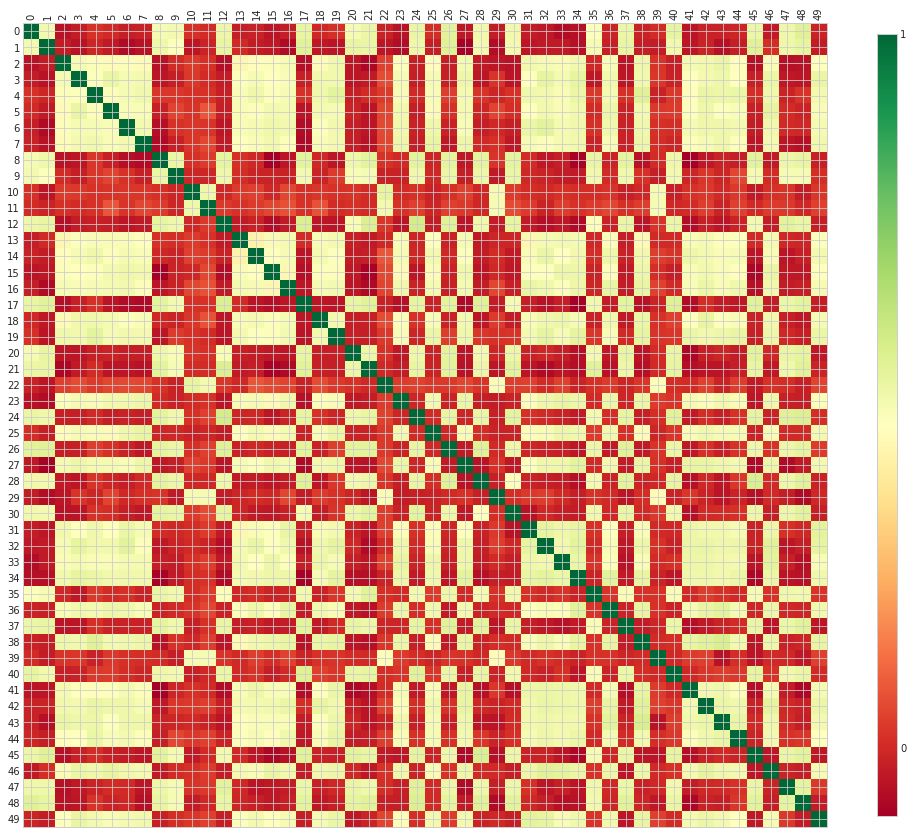

In [4]:
plot_corr(df, size=18)

## Cluster the correlation matrix and visualize it
Here we will perfom only one pass of clustering.

level: 1 shape of the matrix clustered: (1000, 50)


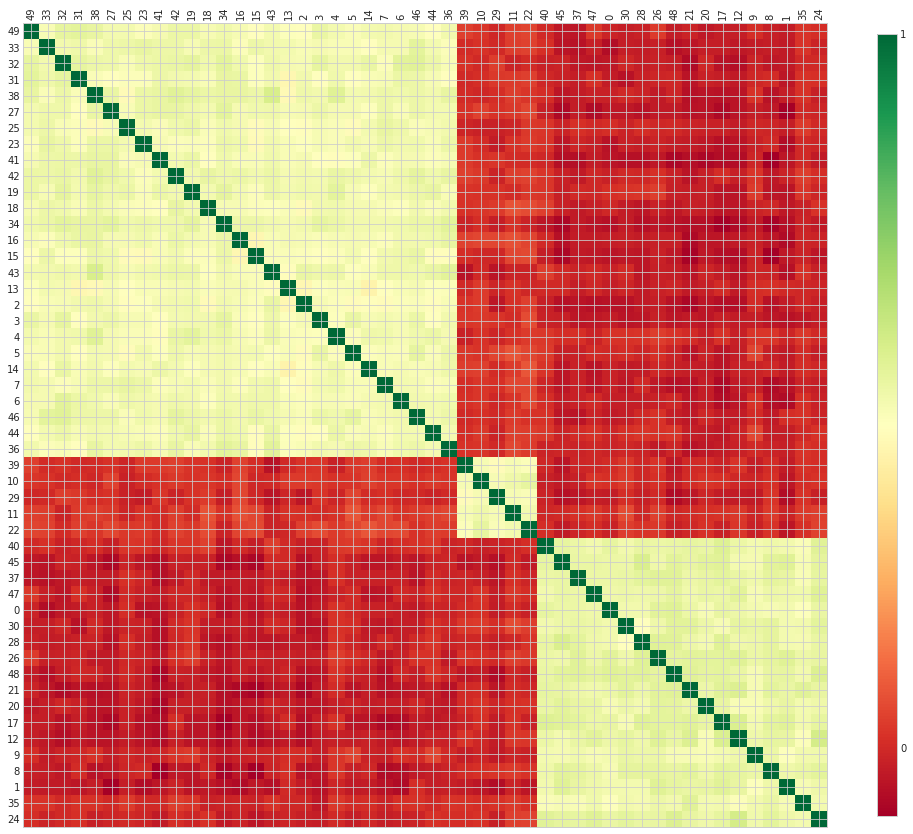

In [5]:
df_1pass = cluster_layer(df, cluster_th=4, max_level=1)
plot_corr(df_1pass, size=18)

## Do a two-pass clustering on the biggest clusters
In the first pass we do as earlier, then for bigger clusters we re-cluster them individually. With this simple toy data, two pass is ample enough. But since we have a generalized approach we could easily perform an n-pass clustering until all sub-clusters are smaller than a threshold simply by setting accordingly 'cluster_th' and 'max_level'.

level: 1 shape of the matrix clustered: (1000, 50)
level: 2 shape of the matrix clustered: (1000, 27)
level: 2 shape of the matrix clustered: (1000, 5)
level: 2 shape of the matrix clustered: (1000, 18)


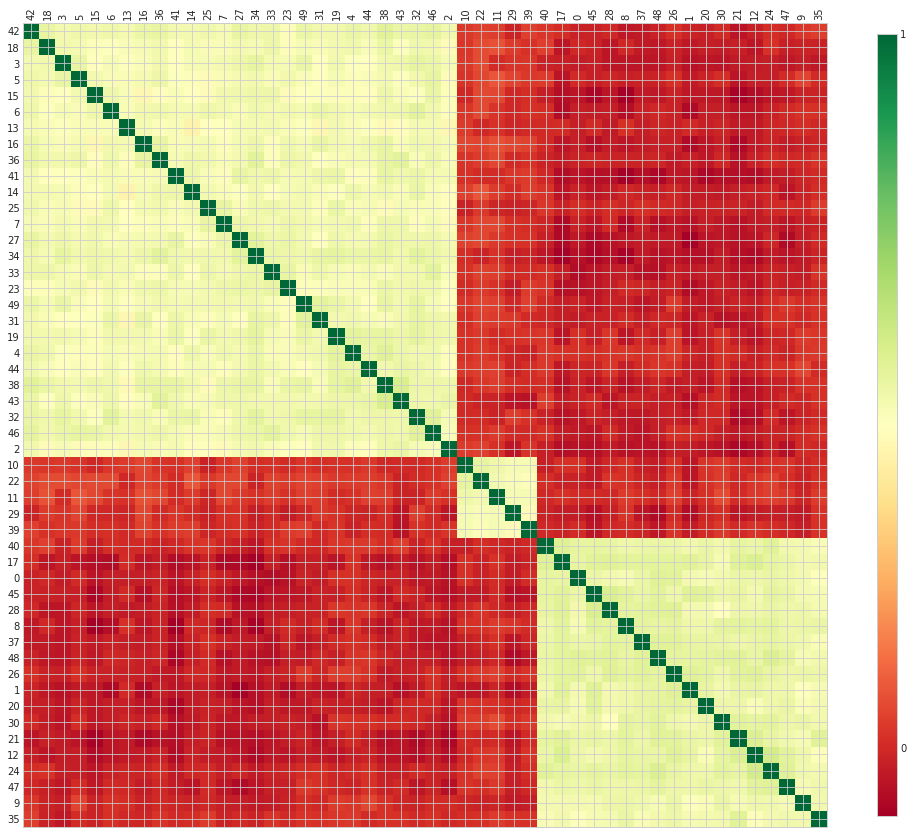

In [6]:
df_2pass = cluster_layer(df, cluster_th=4, max_level=2)
plot_corr(df_2pass, size=18)

## Do an eight-pass clustering on the biggest clusters
Although it will stop after two passes in practice because our toy data is not big enough and varied enough, nothing prevents us from specifying an higher value.

level: 1 shape of the matrix clustered: (1000, 50)
level: 2 shape of the matrix clustered: (1000, 27)
level: 2 shape of the matrix clustered: (1000, 5)
level: 2 shape of the matrix clustered: (1000, 18)


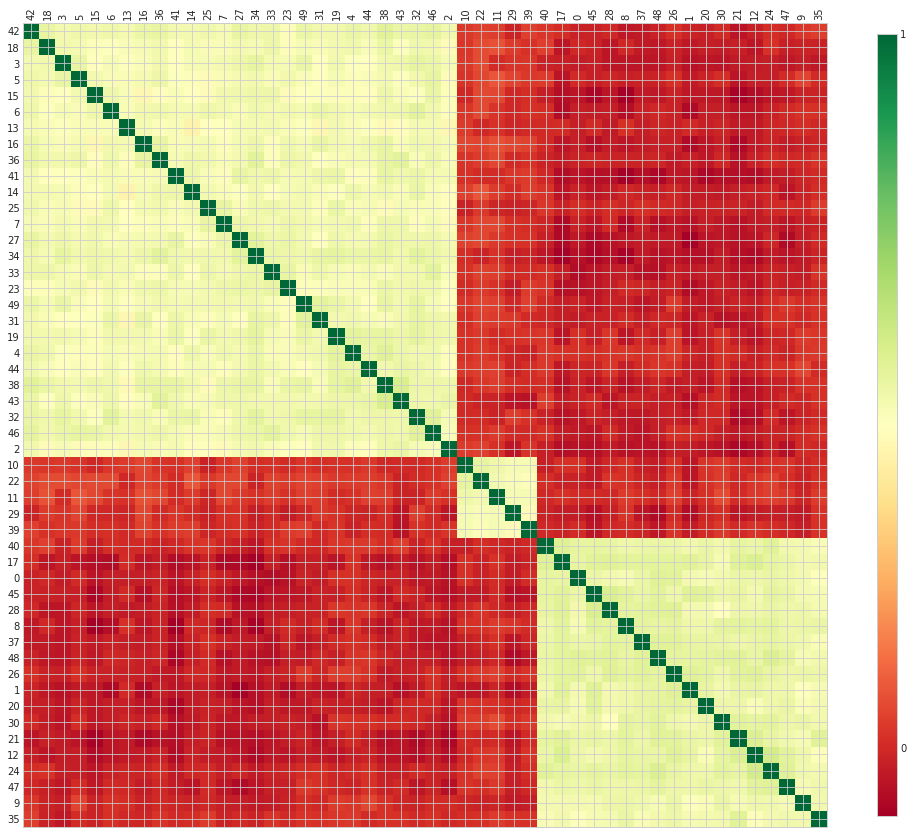

In [7]:
df_8pass = cluster_layer(df, cluster_th=4, max_level=8)
plot_corr(df_8pass, size=18)